In [1]:
import numpy as np      
import os      

import torch
from torch import nn
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms

from torchnet import meter
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split


from IPython.display import clear_output

In [2]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
    
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        b,_,h,w=x.size()
        x=x.view(-1,h*w)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(b,-1,h,w)

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.MNIST(
    root='mnist',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.MNIST(
    root='mnist',
    train=False,
    download=True,
    transform=transform
)

train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=True)

In [8]:
# Parameters
device ='cuda:0' if torch.cuda.is_available() else 'cpu'
print(device,'is available!\n')

model= AutoEncoder().to(device)
print(model)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler=lr_scheduler.CosineAnnealingLR(optimizer,5)

cuda:0 is available!

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)


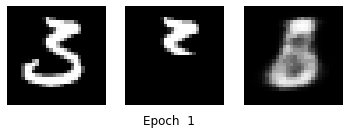

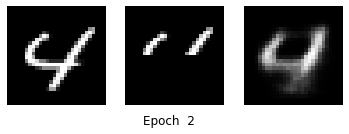

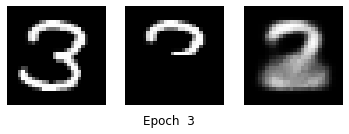

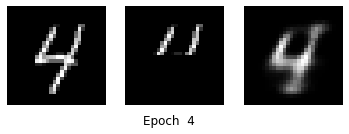

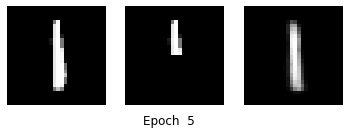

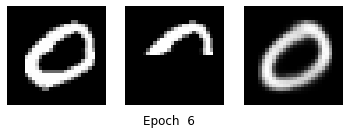

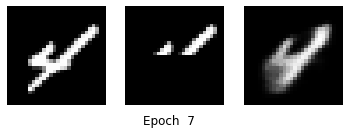

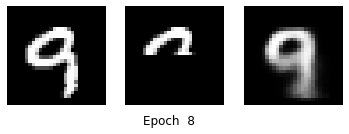

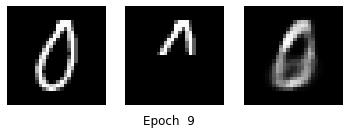

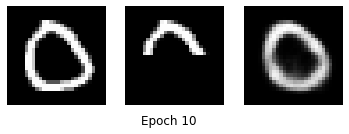

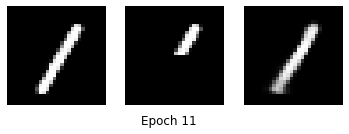

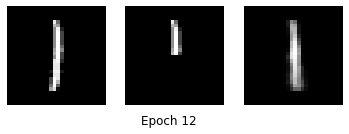

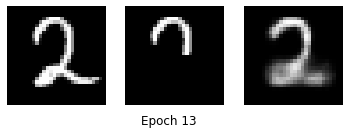

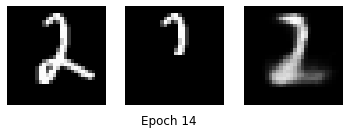

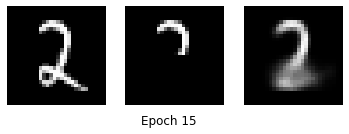

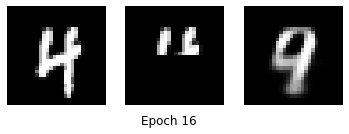

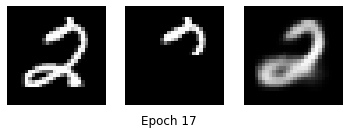

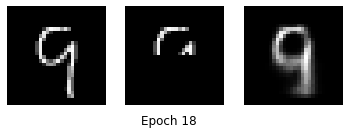

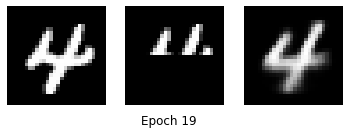

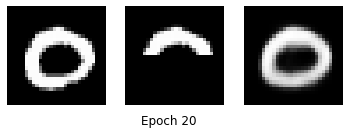

Finished Training


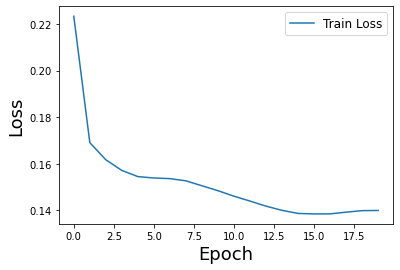

In [9]:
epochs=20
loss_meter = meter.AverageValueMeter()
loss_dic={'train_loss':[], 'valid_loss':[], 'lr':[]}

for epoch in range(epochs):
    
    model.train()
    loss_meter.reset()
    with tqdm(train_loader,leave=False) as tepoch:
        
        for inputs, labels in tepoch:
            tepoch.set_description(f'TrainEpoch{epoch+1:3d}')
            
            _,_,h,w=inputs.size()
            #mask
            msk= torch.ones(inputs.size())
            msk[:,:,h//2:,:]=0 #cover half img

            inputs,target=inputs*msk, inputs
            inputs,target=inputs.to(device), target.to(device)

           
            out = model(inputs)

        
            optimizer.zero_grad()
            crit = criterion(out, target)
            loss_meter.add(crit.item())
            crit.backward()
            optimizer.step()
            
            tepoch.set_postfix({'loss':'{0:.3f}'.format(loss_meter.value()[0])})
    
    loss_dic['train_loss'].append(loss_meter.value()[0])
    #clear_output(wait=True)
    scheduler.step()
    # Show progress
    f, ax = plt.subplots(1,3) 
    ax[0].imshow(torchvision.transforms.ToPILImage()(target[0].view(1,28,28)),cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(torchvision.transforms.ToPILImage()(inputs[0].view(1,28,28)),cmap='gray')
    ax[1].axis('off')
    ax[2].imshow(torchvision.transforms.ToPILImage()(out[0].view(1,28,28)),cmap='gray') 
    ax[2].axis('off')
    f.suptitle(f'Epoch{epoch+1:3d}' ,y=0.3)
    plt.show()

print('Finished Training!')

#plot training loss and valid loss

plt.plot(loss_dic['train_loss'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(["Train Loss"],fontsize=12)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 106.34it/s]


----------------------------------------------------PREDICT----------------------------------------------------


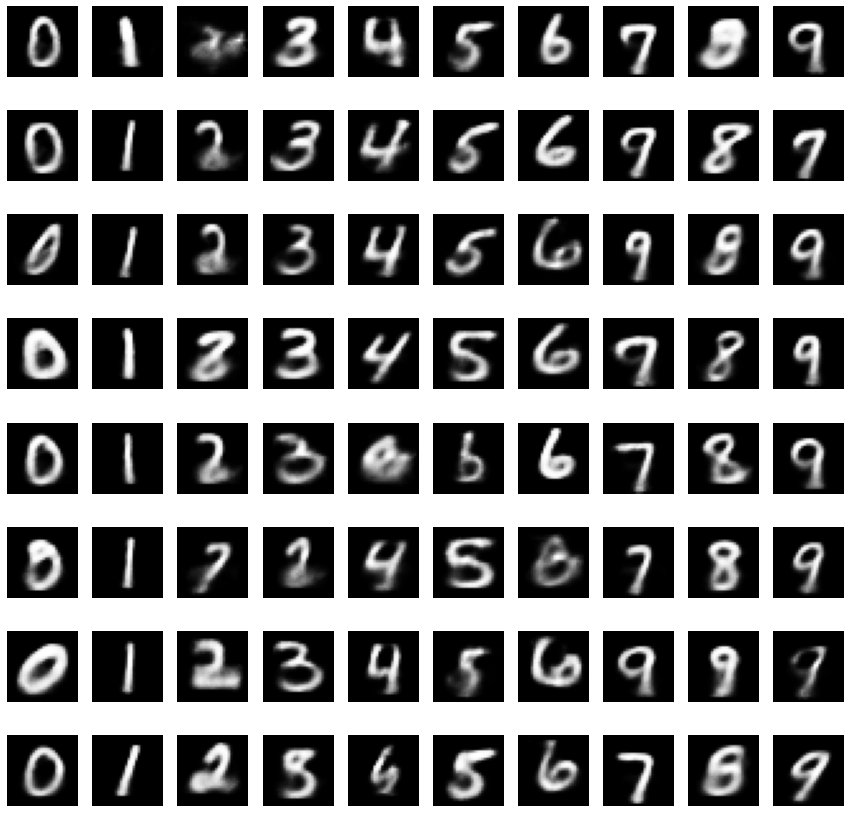

----------------------------------------------------TARGET----------------------------------------------------


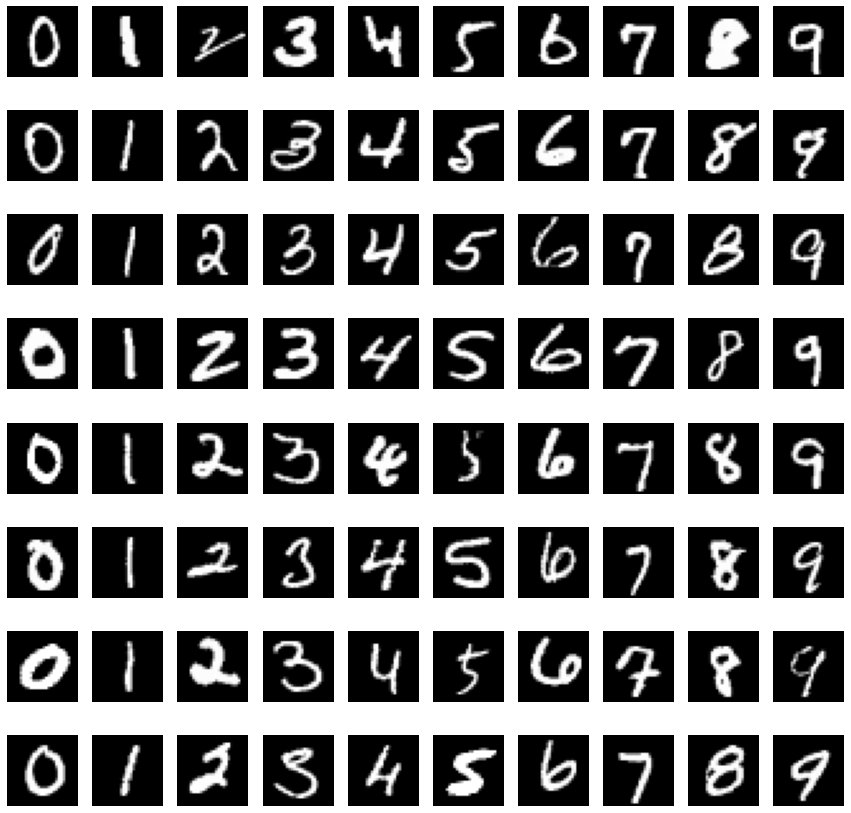

In [10]:
img_set={}
target_set={}
model.eval()
with tqdm(test_loader) as tepoch:
    for img ,label in tepoch:
        _,_,h,w=img.size()
        msk= torch.ones(img.size())
        msk[:,:,h//2:,:]=0 #cover half img

        inputs,target=img*msk, img
        inputs,target=inputs.to(device), target.to(device)
        out = model(inputs)
        for idx in range(len(label)):
            l=int(label[idx].cpu().detach().numpy())
            i=out[idx]
            t=target[idx]
            if l not in img_set:
                img_set[l]=[i]
                target_set[l]=[t]
            else:
                img_set[l].append(i)
                target_set[l].append(t)

print('-'*52+'PREDICT'+'-'*52)
f, ax = plt.subplots(8,10,figsize=(15,15))
for i in range(10):
    for j in range(8):
        ax[j][i].imshow(torchvision.transforms.ToPILImage()(img_set[i][j]),cmap='gray')
        ax[j][i].axis('off')
plt.show()
print('-'*52+'TARGET'+'-'*52)
f, ax = plt.subplots(8,10,figsize=(15,15))
for i in range(10):
    for j in range(8):
        ax[j][i].imshow(torchvision.transforms.ToPILImage()(target_set[i][j]),cmap='gray')
        ax[j][i].axis('off')
plt.show()